In [2]:
ownerpath = f'/Users/mia/Desktop/AST443 Observational Techniques in Astronomy'

In [70]:
import numpy as np
from astropy.io import fits
import glob
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [4]:
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [5]:
dark_frame

[array([[1058, 1028, 1072, ...,  999, 1018,  996],
        [1047, 1038, 1023, ..., 1018, 1088, 1013],
        [1044, 1040, 1031, ..., 1010, 1019, 1033],
        ...,
        [1044, 1039, 1019, ..., 1023, 1034, 1023],
        [1047, 1038, 1035, ..., 1035, 1026, 1019],
        [1046, 1035, 1030, ..., 1024, 1018, 1017]], dtype=uint16),
 array([[1040, 1031, 1029, ..., 1012, 1006, 1013],
        [1063, 1037, 1051, ..., 1028, 1098, 1017],
        [1041, 1030, 1037, ..., 1014, 1029, 1029],
        ...,
        [1032, 1025, 1020, ..., 1030, 1025, 1019],
        [1039, 1031, 1031, ..., 1015, 1024, 1019],
        [1022, 1029, 1026, ..., 1026, 1011, 1030]], dtype=uint16),
 array([[1049, 1034, 1036, ..., 1001, 1022, 1009],
        [1050, 1039, 1051, ..., 1017, 1093, 1008],
        [1054, 1040, 1042, ..., 1018, 1022, 1024],
        ...,
        [1023, 1026, 1041, ..., 1019, 1030, 1014],
        [1042, 1020, 1043, ..., 1027, 1012, 1023],
        [1020, 1036, 1034, ..., 1020, 1011, 1023]], dtype=uint

In [6]:
master_dark_data = np.median(dark_frame, axis=0)

In [7]:
master_dark_data.shape

(1024, 1024)

In [27]:
master_flat = fits.getdata(f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/Normalized_Master_Flat-Field.FIT')

#master_flat_n = (master_flat - master_dark_data)
#master_flat_normalized = master_flat_n / np.median(master_flat_n)

In [28]:
print(master_flat)

[[0.85594257 0.8686863  0.86873272 ... 0.87727914 0.87897659 0.86976982]
 [0.96780562 0.97921523 0.97647225 ... 0.9969022  0.9934399  0.98664038]
 [0.97557592 0.97770703 0.98180826 ... 0.99359777 0.99441197 0.98219269]
 ...
 [0.94814118 0.96646793 0.96787238 ... 0.94909702 0.95116592 0.93904759]
 [0.94878378 0.96353376 0.96635692 ... 0.95475817 0.95520677 0.94150763]
 [0.94960091 0.96560936 0.96833493 ... 0.95365204 0.9498951  0.93953362]]


In [19]:
output_path = f'{ownerpath}/Lab 2'
master_flat_hdu = fits.PrimaryHDU(master_flat)
master_flat_hdu.writeto(f"{output_path}/master_flat.fits", overwrite=True)

In [20]:
science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

In [21]:
science_data.shape

(1024, 1024)

In [23]:
master_bias_frame = fits.getdata(f'{ownerpath}/Lab 2/master_bias_frame.FIT')

In [34]:
calibrated_science_withflat = []
for i in range(194):
    science_corrected = science_data - master_dark_data
    calibrated_data_with =  science_corrected / master_flat
    calibrated_science_withflat.append(calibrated_data_with)

    output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(calibrated_data_with)
    hdu.writeto(output_file_with, overwrite=True)

In [35]:
calibrated_science_withoutflat = []
for i in range(194):
    science_corrected = science_data - master_dark_data
    calibrated_data_without =  science_corrected / np.mean(science_corrected)
    calibrated_science_withoutflat.append(calibrated_science_withoutflat)

    output_file_without = f'{ownerpath}/Lab 2/Subtracted Transient(withoutflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(calibrated_data_without)
    hdu.writeto(output_file_without, overwrite=True)

In [57]:
calibrated_science

[array([[166.81867225, 189.61524225, 185.65410732, ..., 173.41471384,
         177.62629125, 196.35855414],
        [219.67543524, 216.71810384, 223.83044026, ..., 240.83214632,
         225.58067851, 225.67296336],
        [199.37050084, 213.7812835 , 209.39508347, ..., 224.26238066,
         224.27964977, 231.1027297 ],
        ...,
        [211.77998162, 200.32616021, 172.95462552, ..., 191.97064379,
         201.01932404, 176.03032624],
        [205.82440309, 196.26195095, 214.30778067, ..., 205.13312401,
         185.4887085 , 196.19135141],
        [192.07033577, 226.27645888, 224.96628716, ..., 200.62771226,
         204.20227702, 193.97360494]]),
 array([[182.29669339, 166.9485926 , 189.14056943, ..., 170.77388064,
         183.79693164, 164.0684808 ],
        [216.76582682, 206.9118548 , 223.83044026, ..., 235.84597352,
         228.56850207, 215.79668488],
        [210.12087099, 207.91085924, 218.24276306, ..., 202.38312401,
         207.37164956, 216.35149164],
        ...,


In [120]:
data = fits.getdata(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits')   
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print(np.array((mean, median, std)))  

[1106.69364954 1108.19573771   33.78480918]


In [128]:
daofind = DAOStarFinder(fwhm=5.0, threshold=10.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  
sources.pprint(max_width=76)  
sources.write(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ---- -----
  1    233.05     17.36      0.55      -0.12 ... 0.00  937.61 3.52 -1.37
  2    845.66     91.32      0.48      -0.12 ... 0.00 1445.99 5.70 -1.89
  3    830.43    112.71      0.52      -0.36 ... 0.00  608.46 2.27 -0.89
  4    500.55    155.03      0.41      -0.39 ... 0.00  266.74 1.06 -0.06
  5    228.14    160.58      0.56      -0.16 ... 0.00  354.86 1.24 -0.23
  6    938.12    365.84      0.51      -0.19 ... 0.00  581.43 2.27 -0.89
  7    101.51    688.80      0.52      -0.06 ... 0.00  681.63 2.57 -1.03
  8    943.73    905.14      0.40      -0.30 ... 0.00  271.13 1.21 -0.21


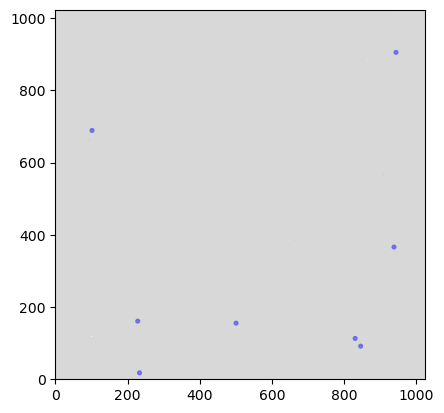

In [129]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [132]:
ast = AstrometryNet()
ast.api_key = 'zxdmyndauvanohii'

sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height, solve_timeout=120)

Solving.....

In [133]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        10.2881685383 / RA  of reference point                         
CRVAL2  =         44.434131942 / DEC of reference point                         
CRPIX1  =              501.4